This notebook consists of five parts:
1. **Input & Utility functions**: import python packages and define some function used in the notebook.
2. **Feature - Subreddits**: extract the subreddit feature and train model based in it.
2. **Feature - Texts**: extract text feature (body of comments) and train model based in it.
4. **Feature - Time**: quick exploration of the time feature.
5. **Features - Subreddits and Text**: combine previous models into a single one.

In [1]:
# Propagate previous outputs to the current version
! cp -r  "/kaggle/input/simone-bertolotto-857533/estimators" "/kaggle/working/"
! cp -r  "/kaggle/input/simone-bertolotto-857533/learning_curves" "/kaggle/working/"
! cp -r  "/kaggle/input/simone-bertolotto-857533/solutions" "/kaggle/working/"
! cp -r  "/kaggle/input/simone-bertolotto-857533/features" "/kaggle/working/"

In [2]:
# Workspace paths
from pathlib import Path

# Path to dirs
input_path = Path("../input")
working_path = Path(".")
temp_path = Path("../temp")

# Create some subdirs if don't exist
(working_path / "estimators").mkdir(exist_ok=True)
(working_path / "solutions").mkdir(exist_ok=True)
(working_path / "learning_curves").mkdir(exist_ok=True)
(working_path / "features").mkdir(exist_ok=True)

# Import & Utility functions

In [3]:
import logging
import multiprocessing
import re
import time
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

# Spacy english model for tokenizer and lemmatazer
import en_core_web_lg

# Save sklearn models
import joblib

# Neural Nets and hyperparmas tuning
import tensorflow as tf
import keras_tuner as kt  # complains about TPU

# Gensim for Doc2Vec, model for paragraph embedding
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models.doc2vec import FAST_VERSION, Doc2Vec, TaggedDocument

# Draw html diagram for sklearn models
from IPython.core.display import HTML, display

# Fit learning curves
from scipy.optimize import curve_fit

# Sklearn models and utility
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.exceptions import NotFittedError
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import RocCurveDisplay, auc, roc_auc_score, roc_curve
from sklearn.model_selection import (
    GridSearchCV,
    ParameterGrid,
    learning_curve,
    train_test_split,
)
from sklearn.naive_bayes import BernoulliNB, ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    Binarizer,
    MaxAbsScaler,
    Normalizer,
    QuantileTransformer,
)
from sklearn.svm import SVC, LinearSVC
from sklearn.utils import estimator_html_repr


In [4]:
# caches location for sklearn preprocessing
caches = joblib.Memory(temp_path)

# number of available CPU cores
CPU = multiprocessing.cpu_count()

# GridSearchCV will be used a lot for validation, so here are the standard parmas used:
GS = dict(
    n_jobs=-1,  # parallel execution on all the available cores
    verbose=1,  # help for backtracing
    return_train_score=True,  # train_score are used for plotting validation curves
    scoring="roc_auc",  # it's a good metric for binary classification of unbalanced dateset
    cv=10,  # more fold reduce variance estimation of validation score
)

# basing logging level for gensim output
# logging.basicConfig(level=logging.INFO)

# check for C libs for gensim
assert FAST_VERSION > -1

# convert python variable into a string, useful for estimators naming
def var2str(var):
    for key, value in globals().items():
        if id(value) == id(var):
            return key


# display sklearn estimator as HTML diagram
def diagram(estimator):
    return display(HTML(f"<div align=center>{estimator_html_repr(estimator)} </div>"))

Training (fit, in sklearn jargon) is a time consuming process, so the trained models shouldn't be lost.
The following custom `fit()` function always save the model. Moreover if there exist an already trained version in
`./estimators` load it instead of train new one. This function is prefer over the scikit-learn standard 
`estimator.fit(X, y=None)` beacuse in `fit()` custom behaviors can be implemented such as:

- timing the fit process
- dynamically load pre-trained estimators
- automatic estimator saving
- automatic estimator naming
- automatic estimator versioning

In [5]:
def fit(estimator, X, y=None, load=True, save=True):

    # can't be ISO 8601 because has to be a valide filename
    now = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
    name = var2str(estimator)

    # search for pre-trained estimators
    estimators = sorted((working_path / "estimators").glob(f"{name}_2021*.joblib"))
    print(f"FOUND\t{len(estimators)} {name} estimators")

    if load and estimators:
        estimator = joblib.load(estimators[-1])
        version = estimators[-1].stem.split("_")[-1]
        estimator.version = version
        estimator.name = name
        print(f"LOAD\t{estimators[-1]}")

    else:
        start_time = time.time()
        estimator.fit(X, y=y)
        estimator.version = now
        estimator.name = name
        elapsed_time = time.gmtime(time.time() - start_time)
        print(f"FIT\t{name} tooks {time.strftime('%X', elapsed_time)}")

        if save:
            path = working_path / "estimators" / f"{name}_{now}.joblib"
            joblib.dump(estimator, path)
            print(f"SAVE\t{name} to {path}")

    print()
    return estimator

Plots can give many insights about machine learning procedures. Here are some
plot function that will be used throughout the notebook:

- `plot_validation_curves`: how validation score changes with respect a single hyperparam
- `plot_validation_heatmaps`: how validation score changes with respect two hyperparams
- `plot_learning_curves`: how validation score changes with different number of training samples
- `plot_svd`: plot high dimensional vector in a 2D plane using SVD (Singular Value Decomposition)
- `plot_roc_curve`: plot ROC (Receiver Operating Characteristic) curve and add AUC (Area Under Curve) score to legend

In [6]:
def plot_mean_std(x, mean, std, logx=True, color="tab:orange", **kwargs):
    plot = plt.semilogx if logx else plt.plot
    plot(x, mean, color=color, **kwargs)
    plt.fill_between(x, mean - std, mean + std, color=color, alpha=0.2)


def plot_heatmap(x, y, score):
    plt.imshow(score, cmap=plt.cm.hot)
    max_y, max_x = np.unravel_index(score.argmax(), score.shape)
    plt.plot(max_x, max_y, "*", color="black")
    plt.colorbar()
    plt.xticks(np.arange(len(y)), y, rotation=45)
    plt.yticks(np.arange(len(x)), x)


def plot_validation_curves(estimator, param, **kwargs):
    cv = pd.DataFrame(estimator.cv_results_)
    score = estimator.best_score_
    x = cv[param].astype(np.float64)
    plt.figure(figsize=(12, 6))
    plt.title(f"Validation curves - {estimator.name}")
    plt.xlabel(param)
    plt.ylabel("Score")
    plot_mean_std(
        x,
        cv["mean_train_score"],
        cv["std_train_score"],
        label="TRAIN",
        linestyle="--",
        **kwargs,
    )
    plot_mean_std(
        x, cv["mean_test_score"], cv["std_test_score"], label="TEST", **kwargs
    )
    plt.axhline(score, color="grey", linestyle="dotted", label=f"{score:.5f}")
    plt.legend(loc="best")
    plt.show()


def plot_validation_heatmaps(estimator, param1, param2):
    cv = pd.DataFrame(estimator.cv_results_)
    x = [
        f"{j:.2}" if i % 2 == 0 else ""
        for i, j in enumerate(cv[param1].unique().astype(float))
    ]
    y = [
        f"{j:.2}" if i % 2 == 0 else ""
        for i, j in enumerate(cv[param2].unique().astype(float))
    ]
    train_score = cv.mean_train_score.values.reshape(len(x), len(y))
    test_score = cv.mean_test_score.values.reshape(len(y), len(x))

    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Validation heatmaps - {estimator.name}")

    plt.subplot(1, 2, 1)
    plt.title(f"TRAIN - ★ {train_score.max():.5f}")
    plot_heatmap(x, y, train_score)
    plt.xlabel(param2)
    plt.ylabel(param1)

    plt.subplot(1, 2, 2)
    plt.title(f"TEST - ★ {test_score.max():.5f}")
    plot_heatmap(x, y, test_score)
    plt.xlabel(param2)
    plt.ylabel(param1)

    plt.show()


def plot_learning_curves(estimator, X, y, extrapolate=0, **kwargs):
    npy = working_path / "learning_curves" / f"{estimator.name}_{estimator.version}.npy"
    name = estimator.name

    if hasattr(estimator, "best_estimator_"):
        estimator = estimator.best_estimator_

    if npy.is_file():
        samples, train_mean, train_std, test_mean, test_std = np.load(npy)

    else:
        samples, train_scores, test_scores = learning_curve(
            estimator,
            X,
            y,
            scoring="roc_auc",
            train_sizes=np.linspace(0.1, 1.0, 10),
            n_jobs=-1,
            verbose=10,
            **kwargs,
        )
        train_mean, train_std = train_scores.mean(axis=1), train_scores.std(axis=1)
        test_mean, test_std = test_scores.mean(axis=1), test_scores.std(axis=1)
        np.save(npy, np.stack((samples, train_mean, train_std, test_mean, test_std)))

    plt.figure(figsize=(12, 6))
    plt.title(f"Learning curves - {name}")
    plt.xlabel("Samples")
    plt.ylabel("Score")
    plot_mean_std(
        samples,
        train_mean,
        train_std,
        logx=False,
        label="TRAIN",
        color="tab:blue",
        linestyle="--",
    )
    plot_mean_std(
        samples, test_mean, test_std, logx=False, label="TEST", color="tab:blue"
    )

    if extrapolate > samples[-1]:
        fit_samples = np.linspace(samples[0], extrapolate * 1.05, 20)

        def func(x, a, b, c):
            # Mazur, J.E., Hastie, R., 1978. Learning as accumulation: a reexamination
            # of the learning curve. Psychological Bulletin 85 (6), 1256e1274.
            return a * ((x + b) / (x + b + c))

        bounds = ([-np.inf, 1e-10, 1e-10], [np.inf, np.inf, np.inf])
        fit_params, _ = curve_fit(func, samples, test_mean, bounds=bounds)
        fit_scores = func(fit_samples, *fit_params)
        fit_score = func(extrapolate, *fit_params)
        plt.plot(fit_samples, fit_scores, linestyle="dotted", alpha=0.5)
        plt.plot(extrapolate, fit_score, "*", label=f"{fit_score:.5f}", color="orange")

    plt.legend(loc="best")
    plt.show()


def plot_svd(X, y, title="SVD"):
    X_svd = TruncatedSVD(2).fit_transform(X)
    color = ["tab:pink" if author else "tab:blue" for author in y]
    plt.scatter(X_svd[:, 0], X_svd[:, 1], marker=".", color=color, alpha=0.8)
    plt.title(title)


def plot_roc_curve(y_test, y_pred, ax, name=""):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    label = f"{name} (AUC = {roc_auc:0.5f})"
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax, name=label)

A simple function that takes an estimator and X_TEST data to produce a CSV file containing predictions (the one submitted to Kaggle).

In [7]:
def solution(estimator, data):
    """
    estimator: sklearn estimator used for prediction with `predict_proba` method
    data: test data in the format expected by the estimator
    """
    path = working_path / "solutions" / f"{estimator.name}_{estimator.version}.csv"
    if path.is_file():
        print(f"SOL. EXISTS AT \t{path}")
        return
    if getattr(estimator, "predict_proba", False):
        prediction = estimator.predict_proba(data)[:, 1]  # sklearn
    else:
        prediction = estimator.predict(data)[:, 0]  # keras
    pd.DataFrame({"author": TEST_AUTHORS, "gender": prediction}).to_csv(
        path, index=False
    )
    print(f"SOL.\t{path}")

Now the three avialable dataset are load in memory as pandas `DataFrame` (explicit type conversion ensure that all columns have the expected type). From these database in the following part of the notebook will be extract feature used for gender classification (*subreddits* and *texts*).

- `Y`: numpy array of training labels sort by author, `array([0, 0, 1, ..., 0, 1, 0])`, `Y.shape == (5000,)`
- `TEST_AUTHORS`: alphabetically sorted list of authors from `test_data`. Their gender prediction will be submitted to Kaggle.

In [8]:
test_data = pd.read_csv(input_path / "datamining2021" / "test_data.csv").astype(
    {"author": str, "subreddit": str, "created_utc": int, "body": str}
)
train_data = pd.read_csv(input_path / "datamining2021" / "train_data.csv").astype(
    {"author": str, "subreddit": str, "created_utc": int, "body": str}
)
train_target = pd.read_csv(
    input_path / "datamining2021" / "train_target.csv", index_col="author", squeeze=True
)

Y = np.array([train_target[author] for author, _ in train_data.groupby("author")])
TEST_AUTHORS = sorted(test_data.author.unique())

# Feature - Subreddits

Two are the important features avaiable in data that can help with the gender prediction: *subreddits* and *text* (text content of a commemnt). I grouped comments by user so I know what he/she wrote and on which subreddits; this give a more insights about user interested and beheavoiur.

In this part of the notebook *subreddits* feature will be explored; variable name (processed data, models, ...) related to this feature start with `S_`. Uppercase datasets variables refer to the whole dataset while lower case datasets is a part of the entire dataset (e.g. `S_TRAIN` contains all 5000 training examples, `S_train` contains 4000 example use to train models and `S_test` contains the remainder 1000 examples for testing purpose).


Subreddits are transform into a vector rappresentation using `CountVectorizer` from sklearn: it converts subreddits (text data) to a matrix of subreddits counts (number). These matrices of occurence counts are named with `S_X_...`.

In [9]:
def subreddits(data):
    return [group.subreddit.str.cat(sep=" ") for _, group in data.groupby("author")]


S_TRAIN = subreddits(train_data)
S_TEST = subreddits(test_data)

# Vectorization of ALL TEST and TRAIN data.
S_VECTORIZER = CountVectorizer(dtype="int", lowercase=False)
S_X_TRAIN = S_VECTORIZER.fit_transform(S_TRAIN)
S_X_TEST = S_VECTORIZER.transform(S_TEST)

# Split TRAIN in train and test. test will be used to evaluate the performance.
S_train, S_test, y_train, y_test = train_test_split(
    S_TRAIN, Y, test_size=0.20, random_state=42, stratify=Y
)

# Vectorization of test and train data.
S_vectorizer = CountVectorizer(dtype="int", lowercase=False)
S_X_train = S_vectorizer.fit_transform(S_train)
S_X_test = S_vectorizer.transform(S_test)

`S_TEST` is splitted into `S_train` and `S_test` using `train_test_split` with the following cautions:
- `random_state` has to be well define so different features can be combine into a single model using pretrained models on same authors.
- `stratify` is important when dealing with unbalanced dataset, it ensure the same unbalanced in the train and in the test datasets.

The reason to used two different vectorizer (`VECTORIZER` and `vectorizer`) is to avoide "`test` dataset contamination". Infact if the vectorizer is fit on the whole data could contains some information about `test` data, an undesiderable circunstance.


*Subreddits* feature can give some insights about users interests; if a user leave a comment on a particular subreddit, he/she is probably interested about that topic. Before feeding a model with data, some preprocessing is required. There are users that wrote hundreds of comments while others just wrote a couple. The purpose of preprocessing is to rescale these differents quantities so the models can yield better predictions.

Six differents types of preprocessing are performed, then the result are passed to a `TruncatedSVD` estimator that squashes high-dimentional features space (number of different subreddits) into a 2d plane. The plots shows that different preprocessing tecniques produce different results. The goal is to separate the blue dots from the pink ones in order to make the life easier for the classifier.

FOUND	1 S_quantile_uniform estimators
LOAD	estimators/S_quantile_uniform_2021-08-23T13-13-20.joblib

FOUND	1 S_quantile_normal estimators
LOAD	estimators/S_quantile_normal_2021-08-23T13-13-52.joblib



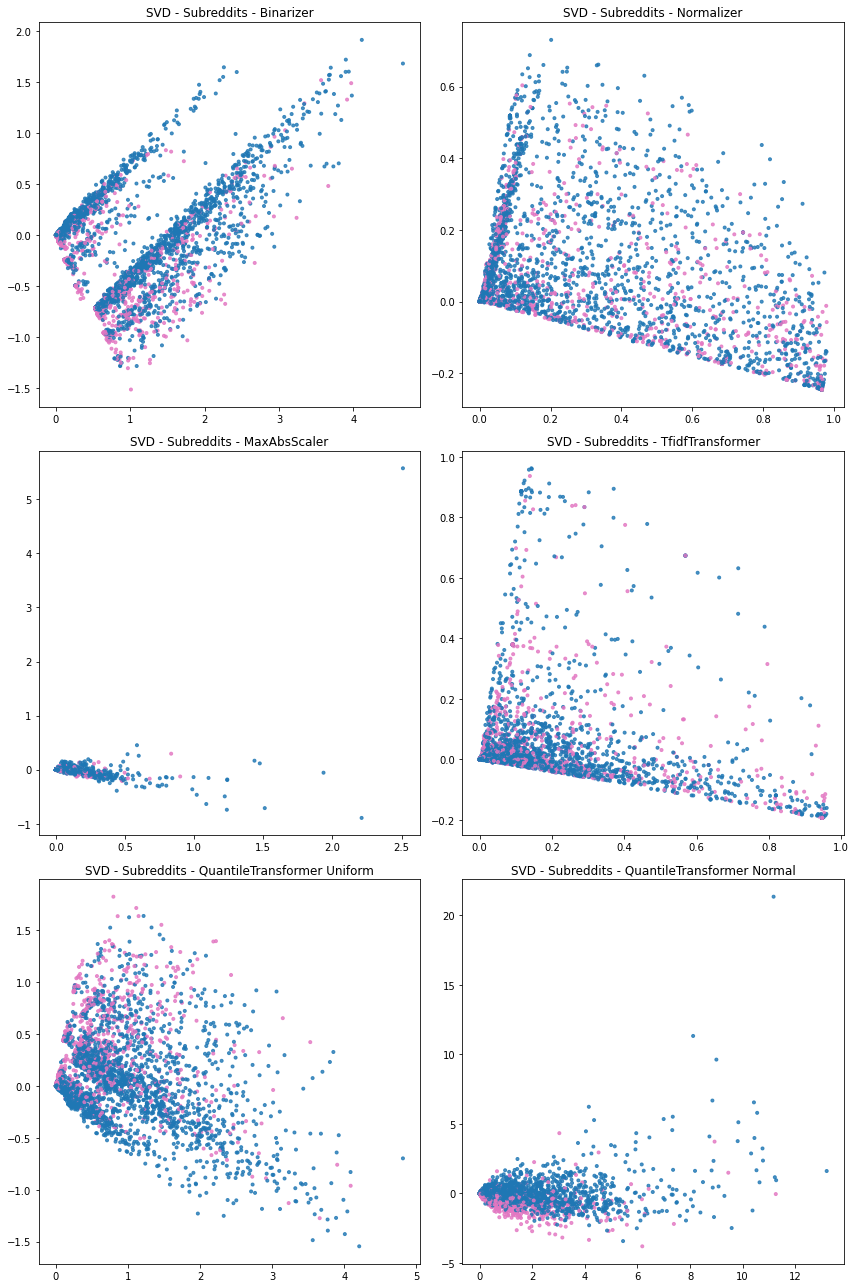

In [10]:
S_quantile_uniform = QuantileTransformer(output_distribution="uniform")
S_quantile_uniform = fit(S_quantile_uniform, S_X_train)
S_quantile_normal = QuantileTransformer(output_distribution="normal")
S_quantile_normal = fit(S_quantile_normal, S_X_train)

names = [
    "Binarizer",
    "Normalizer",
    "MaxAbsScaler",
    "TfidfTransformer",
    "QuantileTransformer Uniform",
    "QuantileTransformer Normal",
]

preprocessors = [
    Binarizer().fit_transform(S_X_train),
    Normalizer().fit_transform(S_X_train),
    MaxAbsScaler().fit_transform(S_X_train),
    TfidfTransformer().fit_transform(S_X_train),
    S_quantile_uniform.transform(S_X_train),
    S_quantile_normal.transform(S_X_train),
]

plt.figure(figsize=(12, 18))
for i, (name, preprocessor) in enumerate(zip(names, preprocessors)):
    plt.subplot(3, 2, i + 1)
    plot_svd(preprocessor, y_train, title=f"SVD - Subreddits - {name}")

plt.tight_layout()
plt.show()

In this notebook I will experimenting with two types of preprocessing:
- `Binarizer`: 1 if user leave a comment on that suberddit otherwise 0. It's simple and computationally fast.
- `QuantileTransformer Normal`: it's a non-linear transformation. It's quite computationally expensive.

## Models

Different models are tried for classification based on subreddits. They are defined using the concept of `Pipeline` that allow to concatenate subsequantial transformations and the classification is done in the last step of the pipeline. The pipeline is nested in a `GridSearchCV` for hyperparams optimization.

Here is the convention for models naming:
- `S_`: The model in  this section are trained on subreddit feature.
- `_preprocessing_`: various preprocessing steps.
- `_classifier`: the classification model at the end of the pipeline.
- `_final`: if the model is trained on the whole dataset and used for Kaggle predictions

*example:*
`S_binarizer_svm_linear` is a model trained on `S_X_train` (not the whole training dataset) that perform "binarization“ followed by a Linear SVM classfication.


### Linear SVM

Linear SVM are succesful models for classification that rely on solid mathematical foundation. Here this model is tested with *binarizer* and *quantile* preprocessing. The hyperparam is only one `C` (proportional to the inverse of regularization) and the best value is determined by cross-validation (to be precise sklearn implements `StratifiedKFold` so each fold is unbalanced as the origianl dataset).


`GridSearchCV` gives us data about hyperparams optimization for free that can be used to construct different plots. When there is just one hyperparam `plot_validation_curves` shows how TRAIN and TEST (it's validation score calculate during grid search) scores change for different value of the hyperparam. The higher validation score is highlighted by a gray dotted line. This type of plot are called `Validation plot`


Learning curves show how much the performance can improve if the model is fitted with different number of training samples. The whole training dataset contains 5000 samples, 4000 are in S_X_train and 1000 in S_X_test. Sample in S_X_train are used for draw learning curves and TEST score is calculated with 5-fold cross-validation. I used `scipy.optimize.curve_fit` to fit TRAIN score and try to predict the score for the model trained on the whole dataset (`len(Y) == 5000`, orange star ★, in the following called **"predicted kaggle score"**).

FOUND	1 S_binarizer_svm_linear estimators
LOAD	estimators/S_binarizer_svm_linear_2021-08-23T13-14-29.joblib



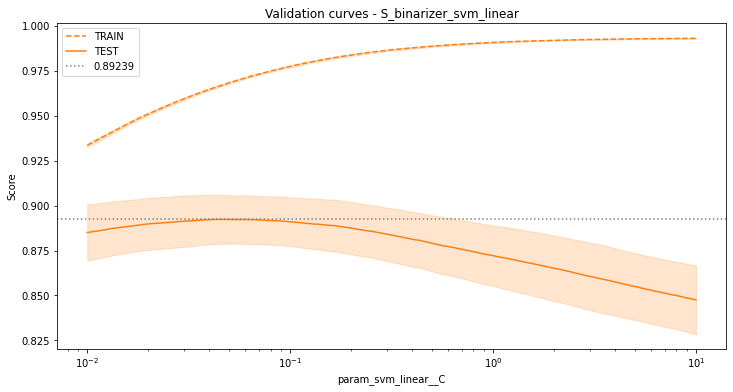

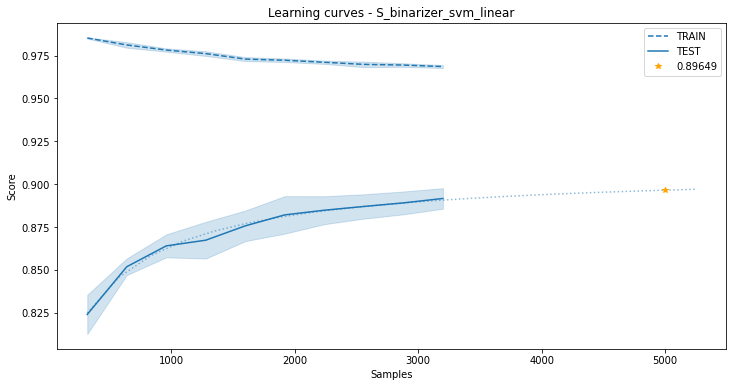

In [11]:
S_binarizer_svm_linear = GridSearchCV(
    Pipeline(
        [
            ("binarizer", Binarizer()),
            (
                "svm_linear",
                LinearSVC(
                    class_weight="balanced",  # account for class imbalance
                    random_state=42,  # repeatability of results
                    max_iter=5000,  # increased for solution convergence
                ),
            ),
        ],
        memory=caches,
    ),
    {
        # logspace for hyperparam interval
        "svm_linear__C": np.logspace(-2, 1, 200),
    },  
    **GS,
)

S_binarizer_svm_linear = fit(S_binarizer_svm_linear, S_X_train, y_train)

diagram(S_binarizer_svm_linear)
plot_validation_curves(S_binarizer_svm_linear, "param_svm_linear__C")
plot_learning_curves(S_binarizer_svm_linear, S_X_train, y_train, len(Y))

`LinearSVC` is implemented with *liblinear* (a library for large linear classification) which scales better than *libsvm* (the library used in `SVC`). The drawback is that *liblinear* does not have a built in probability estimation but a similar result can be obtain using `CalibratedClassifierCV`. After the fit, `S_calibrated_binarizer_svm_linear` is now equipped with `predict_proba` method.

In [12]:
S_calibrated_binarizer_svm_linear = CalibratedClassifierCV(
    S_binarizer_svm_linear.best_estimator_, cv=10
)
S_calibrated_binarizer_svm_linear = fit(
    S_calibrated_binarizer_svm_linear, S_X_train, y_train
)

diagram(S_calibrated_binarizer_svm_linear)

FOUND	1 S_calibrated_binarizer_svm_linear estimators
LOAD	estimators/S_calibrated_binarizer_svm_linear_2021-08-23T13-15-18.joblib



FOUND	1 S_quantile_normal_svm_linear estimators
LOAD	estimators/S_quantile_normal_svm_linear_2021-08-23T13-15-18.joblib



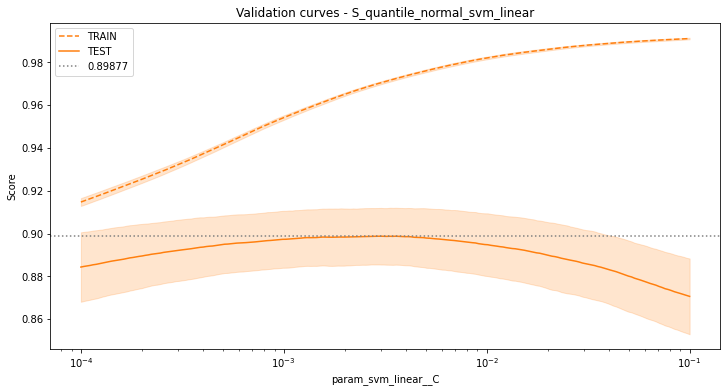

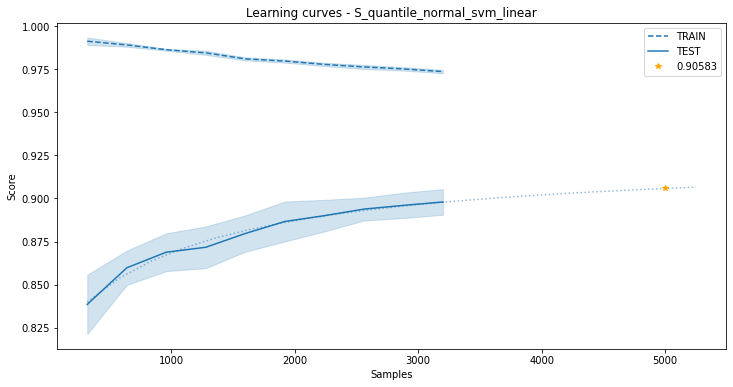

In [13]:
S_quantile_normal_svm_linear = GridSearchCV(
    Pipeline(
        [
            ("quantile", QuantileTransformer(output_distribution="normal")),
            ("svm_linear", LinearSVC(class_weight="balanced", random_state=42)),
        ],
        memory=caches,
    ),
    {
        "svm_linear__C": np.logspace(-4, -1, 200),
    },
    **GS
)

S_quantile_normal_svm_linear = fit(S_quantile_normal_svm_linear, S_X_train, y_train)

diagram(S_quantile_normal_svm_linear)
plot_validation_curves(S_quantile_normal_svm_linear, "param_svm_linear__C")
plot_learning_curves(S_quantile_normal_svm_linear, S_X_train, y_train, len(Y))

In [14]:
S_calibrated_quantile_normal_svm_linear = CalibratedClassifierCV(
    S_quantile_normal_svm_linear.best_estimator_, cv=10
)
S_calibrated_quantile_normal_svm_linear = fit(
    S_calibrated_quantile_normal_svm_linear, S_X_train, y_train
)

diagram(S_calibrated_quantile_normal_svm_linear)

FOUND	1 S_calibrated_quantile_normal_svm_linear estimators
LOAD	estimators/S_calibrated_quantile_normal_svm_linear_2021-08-23T14-28-31.joblib



### Non-Linear SVM

Non-Linear SVM are able to classify data that are not linearly separable. They use the "kernel trick" to map the *input feature space* into a *different feature space* and then perform classification in the latter space.

One difference with the linear SVM is the number of hyperparams. Here there are two hyperparmas in the svm rbf model (`C` and `gamma`) and the model must be optimized for both. A simple 1d-curve is no more sufficient to rappresent how scores vary during GridSearchCV. The GridSearchCV result are organized in a heatmap plots.

FOUND	1 S_binarizer_svm_rbf estimators
LOAD	estimators/S_binarizer_svm_rbf_2021-08-23T15-22-54.joblib



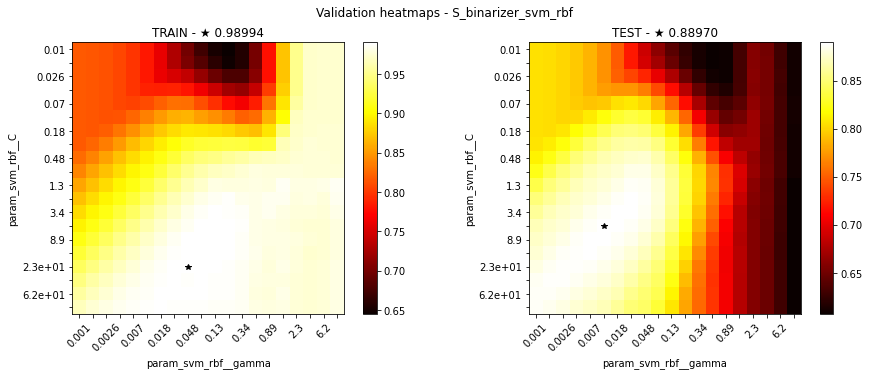

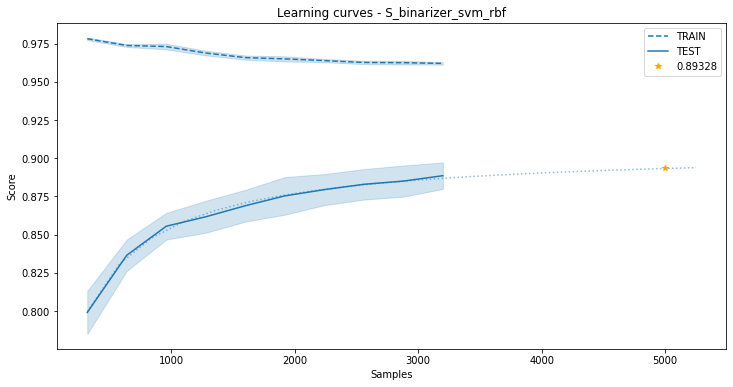

In [15]:
S_binarizer_svm_rbf = GridSearchCV(
    Pipeline(
        [
            ("binarizer", Binarizer()),
            (
                "svm_rbf",
                SVC(
                    kernel="rbf",  # non-linear kernel
                    class_weight="balanced",
                    random_state=42,
                    probability=True,  # built probability estimation
                    cache_size=2000,  # kernel cache, faster traning
                ),
            ),
        ],
        memory=caches,
    ),
    {
        "svm_rbf__C": np.logspace(-2, 2, 20),  # prop to inverse of regularization
        "svm_rbf__gamma": np.logspace(-3, 1, 20),  # rbf param
    },
    **GS
)

S_binarizer_svm_rbf = fit(S_binarizer_svm_rbf, S_X_train, y_train)

diagram(S_binarizer_svm_rbf)
plot_validation_heatmaps(
    S_binarizer_svm_rbf, "param_svm_rbf__C", "param_svm_rbf__gamma"
)
plot_learning_curves(S_binarizer_svm_rbf, S_X_train, y_train, len(Y))

FOUND	1 S_quantile_normal_svm_rbf estimators
LOAD	estimators/S_quantile_normal_svm_rbf_2021-08-24T12-35-23.joblib



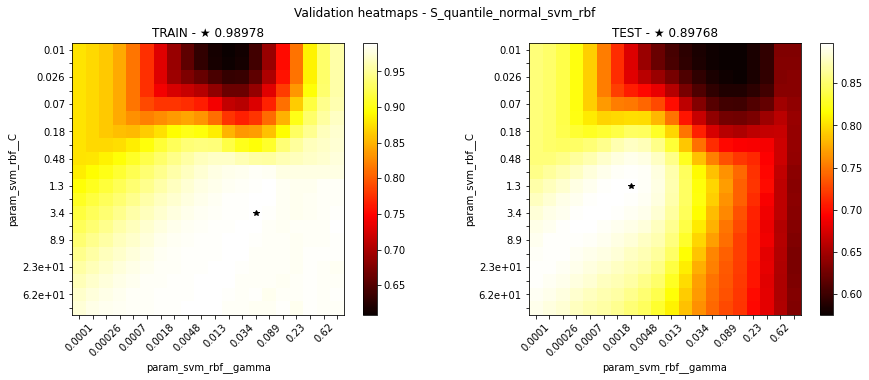

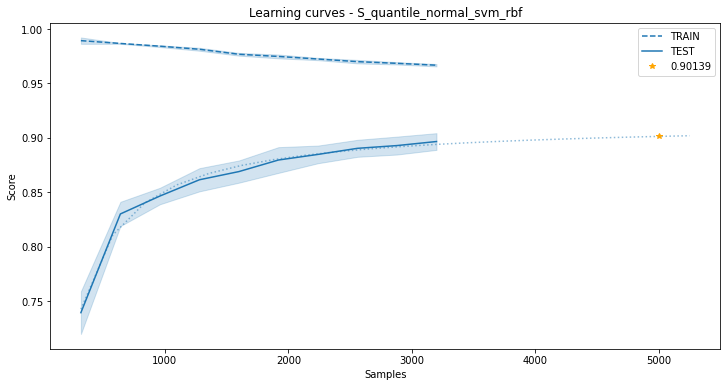

In [16]:
S_quantile_normal_svm_rbf = GridSearchCV(
    Pipeline(
        [
            ("quantile", QuantileTransformer(output_distribution="normal")),
            (
                "svm_rbf",
                SVC(
                    kernel="rbf",
                    class_weight="balanced",
                    random_state=42,
                    probability=True,
                    cache_size=2000,
                ),
            ),
        ],
        memory=caches,
    ),
    {
        "svm_rbf__C": np.logspace(-2, 2, 20),
        "svm_rbf__gamma": np.logspace(-4, 0, 20),
    },
    **GS
)

S_quantile_normal_svm_rbf = fit(S_quantile_normal_svm_rbf, S_X_train, y_train)

diagram(S_quantile_normal_svm_rbf)
plot_validation_heatmaps(
    S_quantile_normal_svm_rbf, "param_svm_rbf__C", "param_svm_rbf__gamma"
)
plot_learning_curves(S_quantile_normal_svm_rbf, S_X_train, y_train, len(Y))

### Naive Bayes

Naive Bayes models leverage the power of Bayes theorem and built upon it. Two type of Naive Bayes model are explored: `ComplementNB` and `BernoulliNB`. BernoulliNB is designed for binary features so the preprocessing step is `Binarizer`. ComplementNB is a modification of MultinomialNB optimized for unbalanced dataset.

FOUND	1 S_binarizer_complement_nb estimators
LOAD	estimators/S_binarizer_complement_nb_2021-08-25T08-58-28.joblib



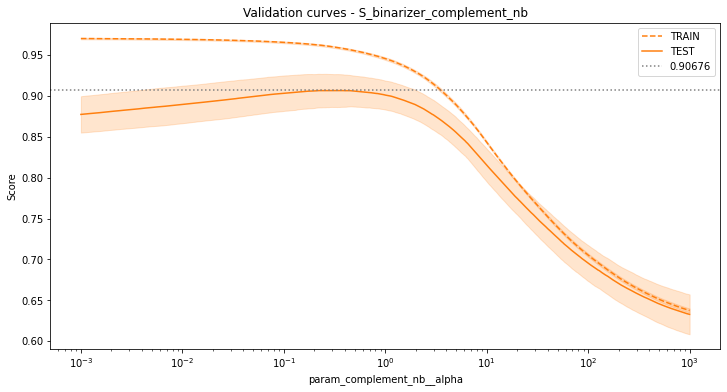

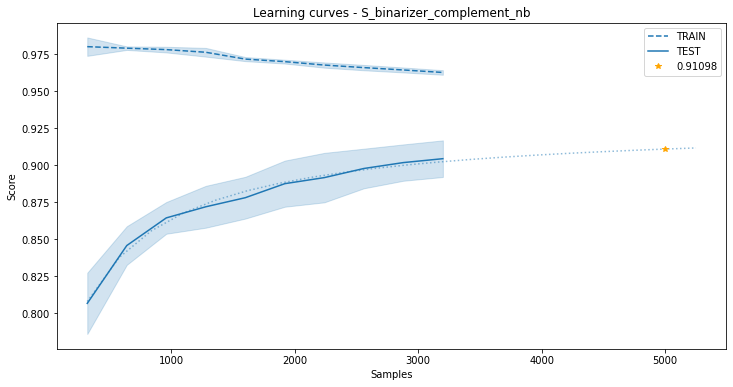

In [17]:
S_binarizer_complement_nb = GridSearchCV(
    Pipeline(
        [
            ("binarizer", Binarizer()),
            ("complement_nb", ComplementNB()),
        ],
        memory=caches,
    ),
    {
        "complement_nb__alpha": np.logspace(-3, 3, 500),
    },
    **GS
)

S_binarizer_complement_nb = fit(S_binarizer_complement_nb, S_X_train, y_train)

diagram(S_binarizer_complement_nb)
plot_validation_curves(S_binarizer_complement_nb, "param_complement_nb__alpha")
plot_learning_curves(S_binarizer_complement_nb, S_X_train, y_train, len(Y))

FOUND	1 S_binarizer_bernoulli_nb estimators
LOAD	estimators/S_binarizer_bernoulli_nb_2021-08-25T08-59-00.joblib



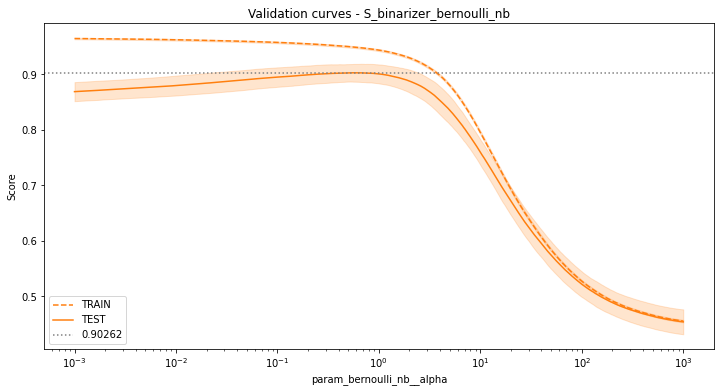

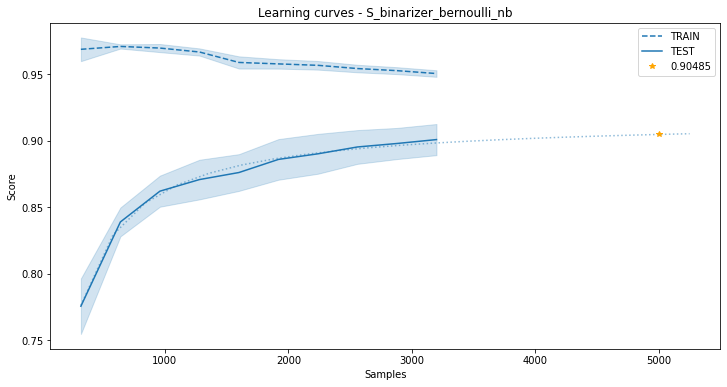

In [18]:
S_binarizer_bernoulli_nb = GridSearchCV(
    Pipeline(
        [
            ("binarizer", Binarizer()),
            ("bernoulli_nb", BernoulliNB()),
        ],
        memory=caches,
    ),
    {
        "bernoulli_nb__alpha": np.logspace(-3, 3, 500),
    },
    **GS
)

S_binarizer_bernoulli_nb = fit(S_binarizer_bernoulli_nb, S_X_train, y_train)

diagram(S_binarizer_bernoulli_nb)
plot_validation_curves(S_binarizer_bernoulli_nb, "param_bernoulli_nb__alpha")
plot_learning_curves(S_binarizer_bernoulli_nb, S_X_train, y_train, len(Y))

### Multi Layer Perceptron

Multi Layer Percepton (MLP) is a combination of simple percepron unit. Due to non lineary of it activation function, MLP is able to classify non liarnly separable data. Unfortuanatly sklearn MLP is not able to digest a 3000-dimensional vector so more preprocessing is required. After the `binarizer` step, I insert a `TruncatedSVD` transformation able to reduce the dimension down to 1500 with limited information loss.

FOUND	1 S_binarizer_svd_mlp estimators
LOAD	estimators/S_binarizer_svd_mlp_2021-08-25T10-38-44.joblib



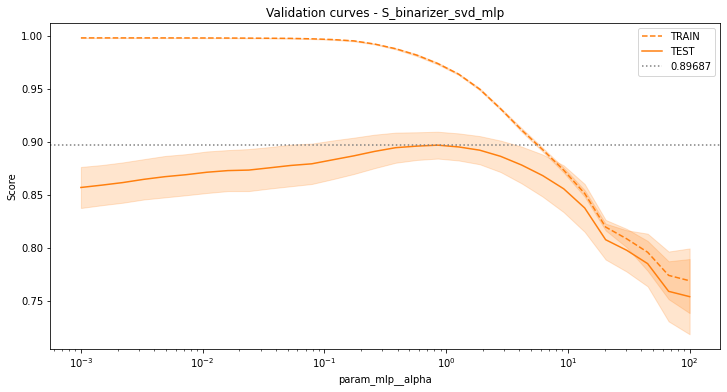

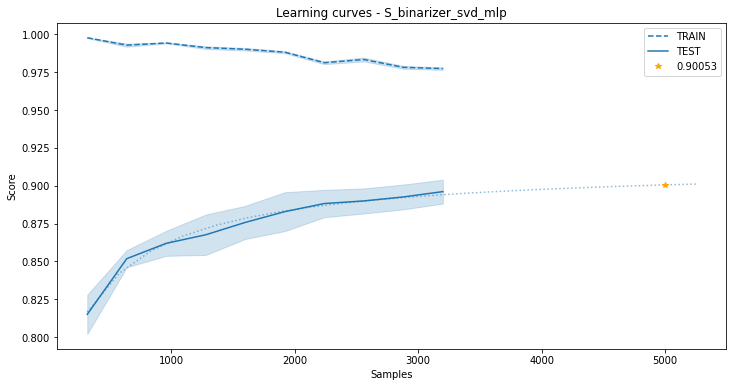

In [19]:
S_binarizer_svd_mlp = GridSearchCV(
    Pipeline(
        [
            ("binarizer", Binarizer()),
            ("svd", TruncatedSVD(n_components=1500)),
            ("mlp", MLPClassifier(max_iter=500, random_state=42)),
        ],
        memory=caches,
    ),
    {
        "mlp__alpha": np.logspace(-3, 2, 30),
    },
    **GS
)

S_binarizer_svd_mlp = fit(S_binarizer_svd_mlp, S_X_train, y_train)

diagram(S_binarizer_svd_mlp)
plot_validation_curves(S_binarizer_svd_mlp, "param_mlp__alpha")
plot_learning_curves(S_binarizer_svd_mlp, S_X_train, y_train, len(Y))

Multi Layer Perceptron seems to yield good predictions so it make sense (litteary) to go deeper. The previous `MLPClassifier` consists of only one hidden layer with 100 neurons. As suggested by sklearn docs, there are other libraries to experimenting with more complex Neural Nets model; one of them is *Keras*, a frendly API on top of tensorflow. For hyperparms optimization `keras_tuner` will be used.

In [20]:
def hypermodel(hp):

    inputs = tf.keras.Input(shape=(S_X_train.shape[1],))
    x = tf.keras.layers.Dense(hp.Choice("units_1", [32, 64, 128]), activation="relu")(
        inputs
    )
    x = tf.keras.layers.Dropout(hp.Float("dropout_1", 0, 0.5))(x)
    x = tf.keras.layers.Dense(hp.Choice("units_2", [16, 32, 64]), activation="relu")(x)
    x = tf.keras.layers.Dropout(hp.Float("dropout_2", 0, 0.5))(x)
    x = tf.keras.layers.Dense(hp.Choice("units_3", [8, 16, 32]), activation="relu")(x)
    x = tf.keras.layers.Dropout(hp.Float("dropout_3", 0, 0.5))(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.AUC(name="roc_auc")],
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
        ),
    )

    return model


tuner = kt.Hyperband(
    hypermodel,
    kt.Objective("val_roc_auc", direction="max"),
    max_epochs=10,
    directory="estimators",
    project_name="S_binarizer_neural_net",
)

tuner.search(
    x=Binarizer().transform(S_X_train).toarray(),  # binarize and densify
    y=y_train[..., np.newaxis],  # [0, 1, ...] -> [[0], [1], ...]
    batch_size=8,
    epochs=10,
    validation_split=0.2,
)

S_binarizer_neural_net = tuner.get_best_models()[0]
S_binarizer_neural_net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3329)]            0         
_________________________________________________________________
dense (Dense)                (None, 128)               426240    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0     

Adding hidden layer slightly improve the test score (see later test score for `MLPClassifier`). However the result are not comparable to other models (e.g. Naive Bayes models). In the following only the sklearn model will be consider.

In [21]:
y_pred = S_binarizer_neural_net.predict(Binarizer().transform(S_X_test).toarray())
print(f"\nBEST ESTIMATOR - Test score (AUC): {roc_auc_score(y_test, y_pred):0.5f}")


BEST ESTIMATOR - Test score (AUC): 0.88881


## Performance

Now it's time to compare the previous models trained on the *subreddit* feature. Area under the Receiver Operating Characteristic curve (`"roc_auc"`) is the chosen metric. Models are evaluated on `S_test` (examples never used during training steps) and result are collect in ROC plot. In the plot legend are shown the test score (higher is better, the perfect score is 1.0).

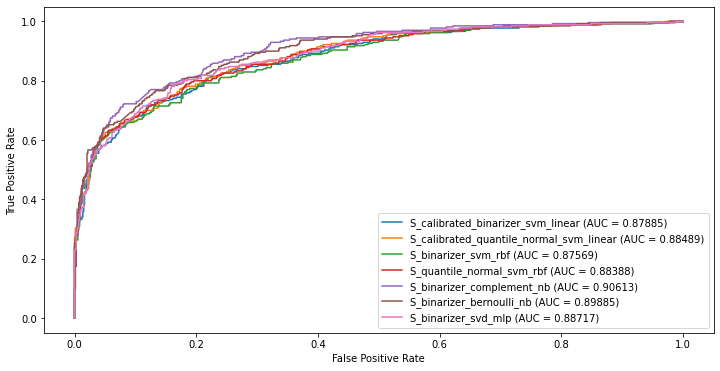

In [22]:
S_estimators = [
    S_calibrated_binarizer_svm_linear,
    S_calibrated_quantile_normal_svm_linear,
    S_binarizer_svm_rbf,
    S_quantile_normal_svm_rbf,
    S_binarizer_complement_nb,
    S_binarizer_bernoulli_nb,
    S_binarizer_svd_mlp,
]


fig, ax = plt.subplots(figsize=(12, 6))

for estimator in S_estimators:
    y_pred = estimator.predict_proba(S_X_test)[:, 1]
    plot_roc_curve(y_test, y_pred, ax, estimator.name)

plt.show()

The best models are the Naive Bayes ones. The others have very similar result. I decied to select one model per "type" for Kaggle evaluation; they are trained on the whole training dataset (`S_TRAIN`) and the predictions are stored in `./solutions` as `csv` file.

In [23]:
# SVM

S_quantile_normal_svm_linear_final = GridSearchCV(
    Pipeline(
        [
            ("quantile", QuantileTransformer(output_distribution="normal")),
            ("svm_linear", LinearSVC(class_weight="balanced", random_state=42)),
        ],
        memory=caches,
    ),
    {
        "svm_linear__C": np.logspace(-4, -1, 200),
    },
    **GS
)

S_quantile_normal_svm_linear_final = fit(
    S_quantile_normal_svm_linear_final, S_X_TRAIN, Y
)
S_calibrated_quantile_normal_svm_linear_final = CalibratedClassifierCV(
    S_quantile_normal_svm_linear_final.best_estimator_, cv=10
)
S_calibrated_quantile_normal_svm_linear_final = fit(
    S_calibrated_quantile_normal_svm_linear_final, S_X_TRAIN, Y
)


# Naive Bayes

S_binarizer_complement_nb_final = GridSearchCV(
    Pipeline(
        [
            ("binarizer", Binarizer()),
            ("complement_nb", ComplementNB()),
        ],
        memory=caches,
    ),
    {
        "complement_nb__alpha": np.logspace(-3, 3, 500),
    },
    **GS
)
S_binarizer_complement_nb_final = fit(S_binarizer_complement_nb_final, S_X_TRAIN, Y)


# MLP

S_binarizer_svd_mlp_final = GridSearchCV(
    Pipeline(
        [
            ("binarizer", Binarizer()),
            ("svd", TruncatedSVD(n_components=1500)),
            ("mlp", MLPClassifier(max_iter=500, random_state=42)),
        ],
        memory=caches,
    ),
    {
        "mlp__alpha": np.logspace(-3, 2, 30),
    },
    **GS
)

S_binarizer_svd_mlp_final = fit(S_binarizer_svd_mlp_final, S_X_TRAIN, Y)

FOUND	1 S_quantile_normal_svm_linear_final estimators
LOAD	estimators/S_quantile_normal_svm_linear_final_2021-08-25T12-59-13.joblib

FOUND	1 S_calibrated_quantile_normal_svm_linear_final estimators
LOAD	estimators/S_calibrated_quantile_normal_svm_linear_final_2021-08-25T14-08-57.joblib

FOUND	1 S_binarizer_complement_nb_final estimators
LOAD	estimators/S_binarizer_complement_nb_final_2021-08-25T14-09-23.joblib

FOUND	1 S_binarizer_svd_mlp_final estimators
LOAD	estimators/S_binarizer_svd_mlp_final_2021-08-25T14-09-55.joblib



In [24]:
solution(S_calibrated_quantile_normal_svm_linear_final, S_X_TEST)
solution(S_binarizer_complement_nb_final, S_X_TEST)
solution(S_binarizer_svd_mlp_final, S_X_TEST)

SOL. EXISTS AT 	solutions/S_calibrated_quantile_normal_svm_linear_final_2021-08-25T14-08-57.csv
SOL. EXISTS AT 	solutions/S_binarizer_complement_nb_final_2021-08-25T14-09-23.csv
SOL. EXISTS AT 	solutions/S_binarizer_svd_mlp_final_2021-08-25T14-09-55.csv


In the table below are summarized the more successful model for each type

|type                    | model                        | test score | predicted kaggle score | kaggle score |
| ---------------------- | ---------------------------- | ---------- | ---------------------- | ------------ |
| Support Vector Machine | S_quantile_normal_svm_linear | 0.88489    | 0.90583                | 0.90684      |
| Naive Bayes            | S_binarizer_complement_nb    | **0.90613**| **0.91098**            | **0.91384**  |
| Multi Layer Perceptron | S_binarizer_svd_mlp          | 0.88717    | 0.90053                | 0.90346      |

## Ensambles

Ensambles tecnique are a way to put together different classifers in order to obtain a better one. I try to combine the previous models (`S_calibrated_binarizer_svm_linear`, `S_binarizer_complement_nb` and `S_binarizer_svd_mlp`) using:

- `StackingClassifier`: stack output of individual classifer and apply linear regression.
- `VotingClassifer`: simple average between the prediction of individual classfier.

In [25]:
S_best_estimators = [
    ("svm", S_calibrated_binarizer_svm_linear),
    ("nb", S_binarizer_complement_nb.best_estimator_),
    ("mpl", S_binarizer_svd_mlp.best_estimator_),
]

In [26]:
S_stacking = GridSearchCV(
    StackingClassifier(
        S_best_estimators,
        LogisticRegression(class_weight="balanced", random_state=42),
        cv=10,
        n_jobs=-1,
        stack_method="predict_proba",
    ),
    {
        "final_estimator__C": np.logspace(-3, 2, 40),
    },
    **GS
)


S_stacking = fit(S_stacking, S_X_train, y_train)

diagram(S_stacking)

FOUND	1 S_stacking estimators
LOAD	estimators/S_stacking_2021-08-26T14-56-40.joblib



In [27]:
S_voting = VotingClassifier(S_best_estimators, voting="soft", n_jobs=-1)

S_voting = fit(S_voting, S_X_train, y_train)

diagram(S_voting)

FOUND	1 S_voting estimators
LOAD	estimators/S_voting_2021-08-26T22-15-57.joblib



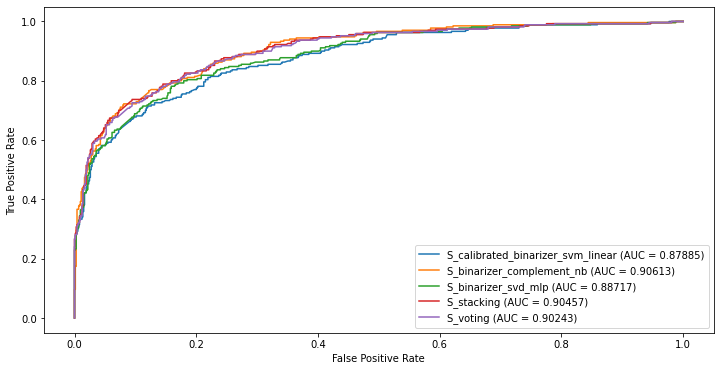

In [28]:
S_estimators = [
    S_calibrated_binarizer_svm_linear,
    S_binarizer_complement_nb,
    S_binarizer_svd_mlp,
    S_stacking,
    S_voting,
]


fig, ax = plt.subplots(figsize=(12, 6))

for estimator in S_estimators:
    y_pred = estimator.predict_proba(S_X_test)[:, 1]
    plot_roc_curve(y_test, y_pred, ax, estimator.name)

plt.show()

The results are not great and the best individual classfier (`S_binarizer_complement_nb`) outperform the composite ones. One of the reason is that `S_binarizer_complement_nb` is already performing a good classfication (`S_binarizer_complement_nb` ROC curve is always above `S_calibrated_binarizer_svm_linear` and `S_binarizer_svd_mlp` curves) and combining it with weaker models produce an average model. However, experimenting with ensamble tecnique will came handy in the future when tring to combine subreddits-based-models with text-based-models.

---
# Feature - Text

The challenging part when dealing with text data (comments text body) is to translate *Natural Language* (what humans understand) to *Vectors of Numbers* (what computer understands). In this part of the notebook more attention will be reserved to text data processing (a.k.a Natural Language Processing, NLP). Text data for each user are concatenated in a single string of text stripped off non-relevant information (e.g. email, url, html, ...). As before `T_TRAIN` contains all training samples, `T_test` is a part of `T_TRAIN` and `T_train` is the other part.

In [29]:
REGEX = [
    re.compile(r"[\w.-]+@[\w.-]+"),  # emails
    re.compile(r"(http|www)[^\s]+"),  # urls
    re.compile(r"[\d]{2,4}[ -/:]*[\d]{2,4}([ -/:]*[\d]{2,4})?"),  # dates
    re.compile("<.*?>"),  # html tags
    re.compile("<!--.*?-->"),  # html comments
    re.compile(r"&gt;"),  # html unescaped
]


def clean_with_regex(text):
    for regex in REGEX:
        text = regex.sub("", text)
    return re.sub(r"[\s]+", " ", text).strip()


def text(data, path, load=True):
    if not load or not path.is_file():
        texts = [
            clean_with_regex(group.body.str.cat(sep=" "))
            for _, group in tqdm(
                data.groupby("author"), desc=f"GENERATING {path.stem} "
            )
        ]
        with open(path, "w") as f:
            for author in texts:
                f.write(f"{author}\n")

    with open(path) as f:
        texts = f.read().splitlines()
    print(f"LOAD {path.stem} from {path}")

    return texts


T_TRAIN = text(train_data, working_path / "features" / "T_TRAIN.txt")
T_TEST = text(test_data, working_path / "features" / "T_TEST.txt")

# Split T_TRAIN in T_train and T_test. test will be used to evaluate the performance.
T_train, T_test, y_train, y_test = train_test_split(
    T_TRAIN, Y, test_size=0.20, random_state=42, stratify=Y
)

LOAD T_TRAIN from features/T_TRAIN.txt
LOAD T_TEST from features/T_TEST.txt


The simplest model is based on Bag of Words (BOW). `CountVectorizer` is used for generate vector representation from user text. The tokenization step is done inside `CountVectorizer` with RegEx and then all words are lowercased. The next step in the pipeline is `TfidfTransformer` that account for frequent term that are irrelevant for classification. Finally classification is preform with `ComplementNB`. Without much overhead this model (`T_complement_nb`) reach a respectable score.

In [30]:
T_complement_nb = GridSearchCV(
    Pipeline(
        [
            ("vectorizer", CountVectorizer(binary=True)),
            ("tfidf", TfidfTransformer()),
            ("nb", ComplementNB()),
        ],
        memory=caches,
    ),
    {
        "vectorizer__max_features": (None, 20000, 35000, 50000, 75000, 90000),
        "vectorizer__max_df": (0.85, 0.9, 0.95, 1.0),
        "tfidf__use_idf": (True, False),
        "tfidf__sublinear_tf": (True, False),
        "nb__alpha": np.logspace(-3, 1, 50),
    },
    n_jobs=-1,
    scoring="roc_auc",
    verbose=1,
)

T_complement_nb = fit(T_complement_nb, T_train, y_train)

diagram(T_complement_nb)
print(f"\nBEST ESTIMATOR - Validation score (AUC): {T_complement_nb.best_score_}")
diagram(T_complement_nb.best_estimator_)

FOUND	1 T_complement_nb estimators
LOAD	estimators/T_complement_nb_2021-09-04T08-13-04.joblib




BEST ESTIMATOR - Validation score (AUC): 0.8785586644765921


A more sophisticated preprocessing can be done using libray like [Spacy](https://spacy.io/). Spacy pretrained pipelines can perform:

1. Tokenization: split text into tokens (~ words, e.g. "New York" is a single token)
2. Lemmatization: convert words into their basic form (e.g. "working" -> "work")
3. Much more ... (but not used in this notebook)

The downside is that kind of preprocessing is time consuming so the preprocessed results are save into `./features` as `txt` file
(each line is a user, tokens are separated by ","). I will refer to these type of preprocessed data as *toKens* (hence `K_TRAIN` and `K_TEST`).


In [31]:
nlp = en_core_web_lg.load(exclude=["parser", "ner"])


def text2token(data, path, load=True):
    if not load or not path.is_file():
        tokens = [
            ",".join(
                [
                    token.lemma_
                    for doc in nlp.pipe(group.body)
                    for token in doc
                    if not (
                        token.is_punct | token.is_space | token.is_stop | token.is_oov
                    )
                ]
            )
            for _, group in tqdm(
                data.groupby("author"), desc=f"GENERATING {path.stem} "
            )
        ]
        with open(path, "w") as f:
            for author in tokens:
                f.write(f"{author}\n")

    with open(path) as f:
        tokens = f.read().splitlines()
    print(f"LOAD {path.stem} from {path}")

    return tokens


K_TRAIN = text2token(train_data, working_path / "features" / f"K_TRAIN.txt")
K_TEST = text2token(test_data, working_path / "features" / f"K_TEST.txt")

K_train, K_test, y_train, y_test = train_test_split(
    K_TRAIN, Y, test_size=0.20, random_state=42, stratify=Y
)

LOAD K_TRAIN from features/K_TRAIN.txt
LOAD K_TEST from features/K_TEST.txt


The following model (`K_complement_nb`) is not much different from the previous (`T_complement_nb`) the preprocessing is handled by Spacy pipeline (`en_core_web_lg`) and `CountVectorizer` split tokens by comma. The improved preprocessing does not result in a increased validation score.

In [32]:
K_complement_nb = GridSearchCV(
    Pipeline(
        [
            (
                "vectorizer",
                CountVectorizer(
                    lowercase=False,
                    binary=True,
                    token_pattern=r"([^,]+)",
                    # same as
                    # tokenizer=lambda x: x.split(","),
                    # but no pickle errors raised.
                ),
            ),
            ("tfidf", TfidfTransformer()),
            ("nb", ComplementNB()),
        ],
        memory=caches,
    ),
    {
        "vectorizer__max_features": (None, 10000, 20000, 30000),
        "vectorizer__max_df": (0.70, 0.75, 0.80, 0.85, 0.9, 0.95, 1.0),
        "tfidf__use_idf": (True, False),
        "tfidf__sublinear_tf": (True, False),
        "nb__alpha": np.logspace(-3, 1, 50),
    },
    n_jobs=-1,
    scoring="roc_auc",
    verbose=1,
)

K_complement_nb = fit(K_complement_nb, K_train, y_train)

diagram(K_complement_nb)
print(f"\nBEST ESTIMATOR - Validation score (AUC): {K_complement_nb.best_score_}")
diagram(K_complement_nb.best_estimator_)

FOUND	1 K_complement_nb estimators
LOAD	estimators/K_complement_nb_2021-09-05T11-04-50.joblib




BEST ESTIMATOR - Validation score (AUC): 0.8756032321070549


Until now BOWs was the way that words were turned in vector of integer numbers (float after tfidf transformation). Another approch is to embed the words into a space as vector of floating number. The following code use `gensim` model `Doc2Vec` for embed entire paragraph into vector of fixed dimension.

In [33]:
"""
Statring from gensim 4.0.0 sklearn_api wrappers are no more maintained
As suggested in the wiki
(https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4)
old chunks of code from Gensim 3.8.3 can be reused and extend
to work with sklearn.

Copyright (C) 2011 Radim Rehurek <radimrehurek@seznam.cz>
Licensed under the GNU LGPL v2.1 - http://www.gnu.org/licenses/lgpl.html
"""


class TqdmCallback(CallbackAny2Vec):
    """Callback for display doc2vec training progress bar."""

    def __init__(self, epochs, desc):
        self.pbar = tqdm(total=epochs, desc=desc)
        self.epoch = 0

    def on_epoch_end(self, model):
        self.pbar.update(1)
        self.epoch += 1

    def on_train_end(self, model):
        self.pbar.close()


class D2VTransformer(TransformerMixin, BaseEstimator):
    """Base Doc2Vec module

    This model based on `Quoc Le, Tomas Mikolov:
    "Distributed Representations of Sentences and Documents"
    <https://cs.stanford.edu/~quocle/paragraph_vector.pdf>`_.
    """

    def __init__(
        self,
        vector_size=100,
        dm=1,
        window=5,
        min_count=0,
        epochs=20,
    ):

        self.model = None
        self.name = f"vec{vector_size}_dm{dm}_min{min_count}"
        self.callbacks = [TqdmCallback(epochs, f"TRAINING EMBEDDING {self.name} ")]

        self.vector_size = vector_size
        self.dm = dm
        self.window = window
        self.min_count = min_count
        self.epochs = epochs

    def fit(self, X, y=None):

        np.random.seed(42)
        np.random.shuffle(X)

        docs = [TaggedDocument(doc.split(","), [i]) for i, doc in enumerate(X)]

        model = Doc2Vec(
            vector_size=self.vector_size,
            dm=self.dm,
            window=self.window,
            min_count=self.min_count,
            epochs=self.epochs,
            sample=0,
            workers=CPU,
            negative=5,
            hs=0,
            callbacks=self.callbacks,
        )

        model.build_vocab(docs)
        model.train(
            docs,
            total_examples=model.corpus_count,
            epochs=model.epochs,
            callbacks=self.callbacks,
        )
        self.model = model

        return self

    def transform(self, X):

        if self.model is None:
            raise NotFittedError(
                "This model has not been fitted yet. Call 'fit' "
                "with appropriate arguments before using this method."
            )

        docs = [doc.split(",") for doc in X]

        return np.array(
            [
                self.model.infer_vector(doc)
                for doc in tqdm(docs, desc=f"GENERATING EMBEDDING {self.name} ")
            ],
            dtype="float32",
        )

I experimented with different embeddings hyperparmas, in particular:

- `vector_size`: 100, 200 and 300 dimensional vector
- `dm`: different algoritm used to trained the model
- `min_count`: disregard words under a certain count treshold.

Then I feed a Logistic Regression model with the various embedding and compare validation scores. 

In [34]:
# E for Embeddings
E_trains = {}
E_tests = {}

grid = {
    "vector_size": (100, 200, 300),
    "dm": (0, 1),
    "min_count": (0, 1, 2),
}


for params in ParameterGrid(grid):
    name = f"vec{params['vector_size']}_dm{params['dm']}_min{params['min_count']}"
    E_TRAIN_path = working_path / "features" / f"E_TRAIN_{name}.npy"

    if not E_TRAIN_path.is_file():
        d2v = D2VTransformer(**params).fit(K_TRAIN + K_TEST)
        np.save(E_TRAIN_path, d2v.transform(K_TRAIN))

    print(f"LOAD {name} from {E_TRAIN_path}")
    E_trains[name], E_tests[name], y_train, y_test = train_test_split(
        np.load(E_TRAIN_path), Y, test_size=0.20, random_state=42, stratify=Y
    )

# for simple CV search it's faster
# than GridSearch(LogisticRegression(...), ...)
lr = LogisticRegressionCV(
    class_weight="balanced",
    random_state=42,
    Cs=np.logspace(-3, -1, 30),
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
)

results = pd.DataFrame(columns=["Embedding", "Score", "C"])
for name, x in E_trains.items():
    lr.fit(x, y_train)
    results.loc[len(results.index)] = (name, lr.scores_[1].mean(axis=0).max(), lr.C_[0])
results.sort_values("Score", ascending=False)

LOAD vec100_dm0_min0 from features/E_TRAIN_vec100_dm0_min0.npy
LOAD vec200_dm0_min0 from features/E_TRAIN_vec200_dm0_min0.npy
LOAD vec300_dm0_min0 from features/E_TRAIN_vec300_dm0_min0.npy
LOAD vec100_dm0_min1 from features/E_TRAIN_vec100_dm0_min1.npy
LOAD vec200_dm0_min1 from features/E_TRAIN_vec200_dm0_min1.npy
LOAD vec300_dm0_min1 from features/E_TRAIN_vec300_dm0_min1.npy
LOAD vec100_dm0_min2 from features/E_TRAIN_vec100_dm0_min2.npy
LOAD vec200_dm0_min2 from features/E_TRAIN_vec200_dm0_min2.npy
LOAD vec300_dm0_min2 from features/E_TRAIN_vec300_dm0_min2.npy
LOAD vec100_dm1_min0 from features/E_TRAIN_vec100_dm1_min0.npy
LOAD vec200_dm1_min0 from features/E_TRAIN_vec200_dm1_min0.npy
LOAD vec300_dm1_min0 from features/E_TRAIN_vec300_dm1_min0.npy
LOAD vec100_dm1_min1 from features/E_TRAIN_vec100_dm1_min1.npy
LOAD vec200_dm1_min1 from features/E_TRAIN_vec200_dm1_min1.npy
LOAD vec300_dm1_min1 from features/E_TRAIN_vec300_dm1_min1.npy
LOAD vec100_dm1_min2 from features/E_TRAIN_vec100_dm1_m

,Embedding,Score,C
3,vec100_dm0_min1,0.903525,0.032903
6,vec100_dm0_min2,0.902555,0.032903
0,vec100_dm0_min0,0.902425,0.028072
4,vec200_dm0_min1,0.902416,0.017433
8,vec300_dm0_min2,0.901825,0.020434
2,vec300_dm0_min0,0.901571,0.020434
1,vec200_dm0_min0,0.901448,0.020434
7,vec200_dm0_min2,0.901428,0.023950
5,vec300_dm0_min1,0.900762,0.014874
9,vec100_dm1_min0,0.873517,0.002593


Embeddings with `dm=0` perform better with no much difference between them, so I went for the simplest of them all: `vector_size=100, dm=0, min_count=0`. With this model I produced the usual `E_TEST` and `E_TRAIN` (`E_` stands for "Embedding").

In [35]:
# Choose one embedding
E_TEST_path = working_path / "features" / f"E_TEST.npy"
E_TRAIN_path = working_path / "features" / f"E_TRAIN.npy"

if not E_TEST_path.is_file() or not E_TRAIN_path.is_file():
    d2v = D2VTransformer(vector_size=100, dm=0, min_count=0).fit(K_TRAIN + K_TEST)
    np.save(E_TEST_path, d2v.transform(K_TEST))
    np.save(E_TRAIN_path, d2v.transform(K_TRAIN))

E_TEST = np.load(E_TEST_path)
print(f"LOAD E_TEST from {E_TEST_path}")
E_TRAIN = np.load(E_TRAIN_path)
print(f"LOAD E_TRAIN from {E_TRAIN_path}")

E_train, E_test, y_train, y_test = train_test_split(
    E_TRAIN, Y, test_size=0.20, random_state=42, stratify=Y
)

LOAD E_TEST from features/E_TEST.npy
LOAD E_TRAIN from features/E_TRAIN.npy


On `E_train` I trained two models:
- `Logistic Regression`: a simple model where the output is the probability to belong to the female class.
- `Neural Net`: 3-layers feed forward neural net able to classify non lineary separable data.

FOUND	1 E_lr estimators
LOAD	estimators/E_lr_2021-09-07T14-21-46.joblib



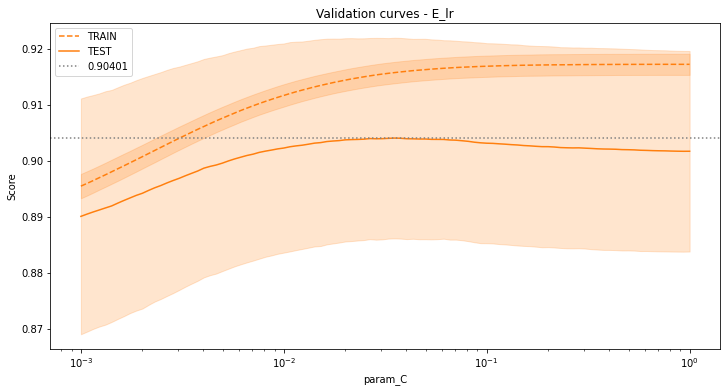

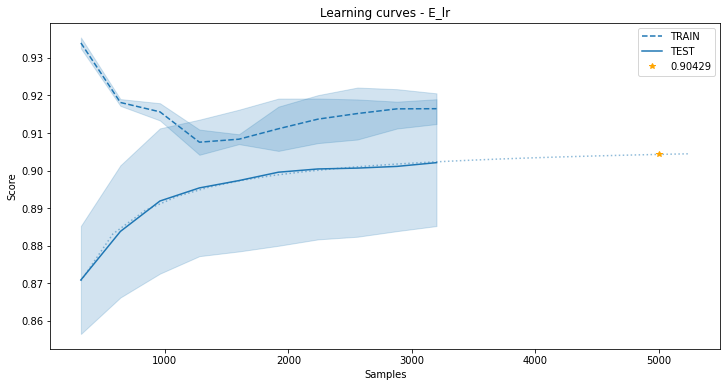

In [36]:
E_lr = GridSearchCV(
    LogisticRegression(
        class_weight="balanced",
        random_state=42,
        n_jobs=-1,
    ),
    {
        "C": np.logspace(-3, 0, 100),
    },
    **GS
)

E_lr = fit(E_lr, E_train, y_train)

diagram(E_lr)
plot_validation_curves(E_lr, "param_C")
plot_learning_curves(E_lr, E_train, y_train, len(Y))

In [37]:
def hypermodel(hp):

    inputs = tf.keras.Input(shape=(100,))
    x = tf.keras.layers.Dense(hp.Choice("units_1", [32, 64, 128]), activation="relu")(
        inputs
    )
    x = tf.keras.layers.Dropout(hp.Float("dropout_1", 0, 0.5))(x)
    x = tf.keras.layers.Dense(hp.Choice("units_2", [16, 32, 64]), activation="relu")(x)
    x = tf.keras.layers.Dropout(hp.Float("dropout_2", 0, 0.5))(x)
    x = tf.keras.layers.Dense(hp.Choice("units_3", [8, 16, 32]), activation="relu")(x)
    x = tf.keras.layers.Dropout(hp.Float("dropout_3", 0, 0.5))(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.AUC(name="roc_auc")],
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
        ),
    )

    return model


tuner = kt.Hyperband(
    hypermodel,
    kt.Objective("val_roc_auc", direction="max"),
    max_epochs=15,
    hyperband_iterations=7,
    seed=42,
    directory="estimators",
    project_name="E_neural_net",
)

tuner.search(
    x=E_train,
    y=y_train[..., np.newaxis],
    batch_size=8,
    epochs=10,
    validation_split=0.2,
)

E_neural_net = tuner.get_best_models()[0]
E_neural_net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0     

## Performance

It's time to compare the performance of different text-based classifier trained on different preprocessing steps (sklearn-BOW, spacy-skelarn-BOW, spacy-gensim-embedding). it is a satisfactory result: the finer is the preprocessing, the higher is the test score.

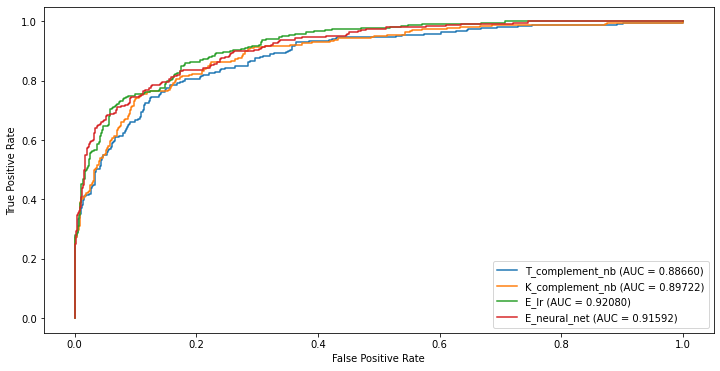

In [38]:
fig, ax = plt.subplots(figsize=(12, 6))

y_pred = T_complement_nb.predict_proba(T_test)[:, 1]
plot_roc_curve(y_test, y_pred, ax, "T_complement_nb")
y_pred = K_complement_nb.predict_proba(K_test)[:, 1]
plot_roc_curve(y_test, y_pred, ax, "K_complement_nb")
y_pred = E_lr.predict_proba(E_test)[:, 1]
plot_roc_curve(y_test, y_pred, ax, "E_lr")
y_pred = E_neural_net.predict(E_test)
plot_roc_curve(y_test, y_pred, ax, "E_neural_net")

plt.show()

In [39]:
# TEXT
T_complement_nb_final = GridSearchCV(
    Pipeline(
        [
            ("vectorizer", CountVectorizer(binary=True)),
            ("tfidf", TfidfTransformer(use_idf=False, sublinear_tf=True)),
            ("nb", ComplementNB()),
        ],
        memory=caches,
    ),
    {
        "vectorizer__max_features": (None, 20000, 35000, 40000, 50000),
        "vectorizer__max_df": (0.85, 0.9, 0.95, 1.0),
        "nb__alpha": np.logspace(-3, 1, 100),
    },
    n_jobs=-1,
    scoring="roc_auc",
    verbose=1,
)

T_complement_nb_final = fit(T_complement_nb_final, T_TRAIN, Y)

# TOKEN
K_complement_nb_final = GridSearchCV(
    Pipeline(
        [
            (
                "vectorizer",
                CountVectorizer(
                    lowercase=False,
                    binary=True,
                    token_pattern=r"([^,]+)",
                ),
            ),
            ("tfidf", TfidfTransformer(use_idf=False, sublinear_tf=True)),
            ("nb", ComplementNB()),
        ],
        memory=caches,
    ),
    {
        "vectorizer__max_features": (None, 20000, 30000, 40000),
        "vectorizer__max_df": (0.65, 0.70, 0.75, 0.80, 0.85, 0.9, 1.0),
        "nb__alpha": np.logspace(-3, 1, 100),
    },
    n_jobs=-1,
    scoring="roc_auc",
    verbose=1,
)

K_complement_nb_final = fit(K_complement_nb_final, K_TRAIN, Y)

# EMBEDDING LR
E_lr_final = GridSearchCV(
    LogisticRegression(
        class_weight="balanced",
        random_state=42,
        n_jobs=-1,
    ),
    {
        "C": np.logspace(-3, 0, 500),
    },
    **GS
)

E_lr_final = fit(E_lr_final, E_TRAIN, Y)

# EMBEDDING NN
tuner = kt.Hyperband(
    hypermodel,
    kt.Objective("val_roc_auc", direction="max"),
    max_epochs=15,
    hyperband_iterations=11,
    seed=42,
    directory="estimators",
    project_name="E_neural_net_final",
)

tuner.search(
    x=E_TRAIN,
    y=Y[..., np.newaxis],
    batch_size=8,
    epochs=10,
    validation_split=0.2,
)

E_neural_net_final = tuner.get_best_models()[0]
E_neural_net_final.version = "E_neural_net_final_2021-09"

FOUND	1 T_complement_nb_final estimators
LOAD	estimators/T_complement_nb_final_2021-09-07T14-47-03.joblib

FOUND	1 K_complement_nb_final estimators
LOAD	estimators/K_complement_nb_final_2021-09-07T20-53-14.joblib

FOUND	1 E_lr_final estimators
LOAD	estimators/E_lr_final_2021-09-07T23-50-46.joblib



In [40]:
solution(T_complement_nb_final, T_TEST)
solution(K_complement_nb_final, K_TEST)
solution(E_lr_final, E_TEST)
solution(E_neural_net_final, E_TEST)

SOL. EXISTS AT 	solutions/T_complement_nb_final_2021-09-07T14-47-03.csv
SOL. EXISTS AT 	solutions/K_complement_nb_final_2021-09-07T20-53-14.csv
SOL. EXISTS AT 	solutions/E_lr_final_2021-09-07T23-50-46.csv
SOL. EXISTS AT 	solutions/model_E_neural_net_final_2021-09.csv


Here are the results for models trained on text data

| preprocessing          | model                 | test score | kaggle score |
| ---------------------- | --------------------- | ---------- | ------------ |
| sklearn-BOW            | T_complement_nb_final | 0.88660    | 0.88813      |
| spacy-skelarn-BOW      | K_complement_nb_final | 0.89722    | 0.88780      |
| spacy-gensim-embedding | E_lr_final            |**0.92080** | **0.91150**  |
| spacy-gensim-embedding | E_neural_net_final    | 0.91592    | 0.90501      |

----
# Feature - Time

Another feature associated to each comment is *time* (when the comment was posted rappresent as unix epoch). If one gender, on average, starts to use Reddit earlier than the other, this feature can be meaninful for classification. Unfortunatly comments in the database belong to one month (2014-01 to 2014-02) so this beaviour cannot be observed. The following density-histogram shows that males and females comment follow the same distribution so no useful information can be extracted from this feature.

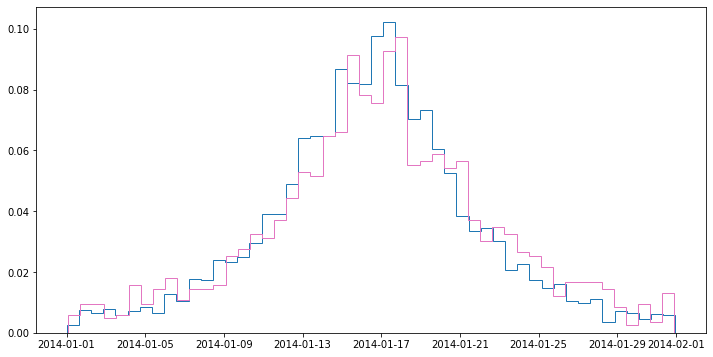

In [41]:
males, females = [], []
for author, group in train_data.groupby("author"):
    if train_target[author]:
        females.append(group.created_utc.mean())
    else:
        males.append(group.created_utc.mean())

plt.figure(figsize=(12, 6))
plt.hist(
    pd.to_datetime(males, unit="s"),
    density=True,
    bins=50,
    histtype="step",
    color="tab:blue",
)
plt.hist(
    pd.to_datetime(females, unit="s"),
    density=True,
    bins=50,
    histtype="step",
    color="tab:pink",
)
plt.show()

---
# Features - Subreddits and Text

To develop a model that (teoretically) can perform even better, all the relevant information contained in the training data should be used. This can be achived in models that combine subreddits-feature with text-feature. In the following I try to combine the previous models (that were successful) into a single one.

- **Soft voting classifier**: a simple average between the predictions of different classifier weighed by individual test scores.
- **Logistic regression**: stack the predictions from differnt classifers and then pass to a logistic regression estimator.

In [42]:
S_nb_y_train = S_binarizer_complement_nb.predict_proba(S_X_train)[:, 1]
E_lr_y_train = E_lr.predict_proba(E_train)[:, 1]

S_nb_y_test = S_binarizer_complement_nb.predict_proba(S_X_test)[:, 1]
E_lr_y_test = E_lr.predict_proba(E_test)[:, 1]

SE_y_train = np.stack([S_nb_y_train, E_lr_y_train], axis=1)
SE_y_test = np.stack([S_nb_y_test, E_lr_y_test], axis=1)

In [43]:
# simple soft voting classifier
scores = [
    roc_auc_score(y_test, S_nb_y_test),
    roc_auc_score(y_test, E_lr_y_test),
]
SE_y_soft_voting = np.average(SE_y_test, axis=1, weights=scores)

In [44]:
# logistic regression
SE_lr = LogisticRegressionCV(
    class_weight="balanced",
    random_state=42,
    Cs=np.logspace(-6, -3, 200),
    cv=10,
    scoring="roc_auc",
    n_jobs=-1,
)

SE_lr.fit(SE_y_train, y_train)
SE_y_lr = SE_lr.predict_proba(SE_y_test)[:, 1]

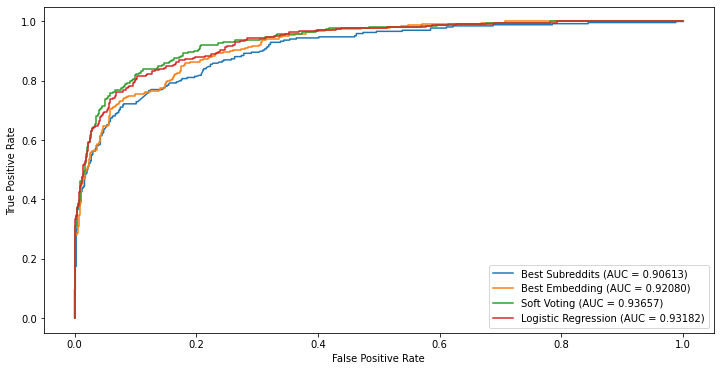

In [45]:
fig, ax = plt.subplots(figsize=(12, 6))

plot_roc_curve(y_test, S_nb_y_test, ax, "Best Subreddits")
plot_roc_curve(y_test, E_lr_y_test, ax, "Best Embedding")
plot_roc_curve(y_test, SE_y_soft_voting, ax, "Soft Voting")
plot_roc_curve(y_test, SE_y_lr, ax, "Logistic Regression")

Test score of the combine classifier definitly out perform classifer trained on only one feature. *Soft Voting* seems to perform slightly better than *Logistic Regression*. Now "train" the classifers on the entire training datasets for the final Kaggle score.

In [46]:
S_nb_y_TRAIN = S_binarizer_complement_nb_final.predict_proba(S_X_TRAIN)[:, 1]
E_lr_y_TRAIN = E_lr_final.predict_proba(E_TRAIN)[:, 1]

S_nb_y_TEST = S_binarizer_complement_nb_final.predict_proba(S_X_TEST)[:, 1]
E_lr_y_TEST = E_lr_final.predict_proba(E_TEST)[:, 1]

SE_y_TRAIN = np.stack([S_nb_y_TRAIN, E_lr_y_TRAIN], axis=1)
SE_y_TEST = np.stack([S_nb_y_TEST, E_lr_y_TEST], axis=1)


# simple soft voting classifier
SE_y_soft_voting_final = np.average(SE_y_TEST, axis=1, weights=scores)
pd.DataFrame({"author": TEST_AUTHORS, "gender": SE_y_soft_voting_final}).to_csv(
    working_path / "solutions" / f"SE_soft_voting.csv",
    index=False,
)

# logistic regression
SE_lr_final = LogisticRegressionCV(
    class_weight="balanced",
    random_state=42,
    Cs=np.logspace(-7, -3, 200),
    cv=10,
    scoring="roc_auc",
    n_jobs=-1,
)
SE_lr_final.fit(SE_y_TRAIN, Y)
SE_y_lr_final = SE_lr_final.predict_proba(SE_y_TEST)[:, 1]
pd.DataFrame({"author": TEST_AUTHORS, "gender": SE_y_lr_final}).to_csv(
    working_path / "solutions" / f"SE_lr.csv",
    index=False,
)

Here are the results:

| model                                                             | test score | kaggle score |
| ----------------------------------------------------------------- | ---------- | ------------ |
| Soft classifier (Naive Bayes + Embedding Logistic Regression)     | **0.93657**| **0.93874**  |
| Logistic Regression (Naive Bayes + Embedding Logistic Regression) | 0.93182    | 0.93561      |